In [99]:
import numpy as np
import pandas as pd
import yfinance as yf
from scipy.stats import skew, kurtosis
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import cyipopt
import warnings
warnings.filterwarnings('ignore')

In [100]:
tickers = ['BBCA.JK', 'BBRI.JK', 'BMRI.JK', 'BBNI.JK']
ticker_names = ['BBCA', 'BBRI', 'BMRI', 'BBNI']

start_date = '2022-01-01'
end_date = '2025-10-31'

print(f"\nMengunduh data dari {start_date} hingga {end_date}...")
data = yf.download(tickers, start=start_date, end=end_date, progress=False, auto_adjust=False)['Adj Close']
data.columns = ticker_names

print(f"Data berhasil diunduh: {len(data)} hari perdagangan")
print(f"\nSample data terakhir:")
print(data.tail())

returns = np.log(data / data.shift(1)).dropna()

print(f"\nJumlah return harian: {len(returns)}")
print(f"\nStatistik Return Harian:")
print(returns.describe())


Mengunduh data dari 2022-01-01 hingga 2025-10-31...
Data berhasil diunduh: 917 hari perdagangan

Sample data terakhir:
              BBCA    BBRI    BMRI    BBNI
Date                                      
2025-10-24  8275.0  4370.0  3850.0  4550.0
2025-10-27  8350.0  4370.0  3860.0  4470.0
2025-10-28  8275.0  4370.0  3850.0  4510.0
2025-10-29  8600.0  4440.0  3890.0  4650.0
2025-10-30  8525.0  4410.0  3910.0  4800.0

Jumlah return harian: 916

Statistik Return Harian:
             BBCA        BBRI        BMRI        BBNI
count  916.000000  916.000000  916.000000  916.000000
mean     0.000277    0.000507    0.000190    0.000601
std      0.014691    0.018939    0.018179    0.018952
min     -0.089153   -0.083382   -0.106733   -0.107500
25%     -0.008535   -0.009009   -0.009615   -0.009081
50%      0.000000    0.000000    0.000000    0.000000
75%      0.008197    0.009479    0.009346    0.010168
max      0.073427    0.085942    0.088251    0.084475


In [101]:
mu = returns.mean().values
print(f"\nExpected Returns (μ):")
for i, name in enumerate(ticker_names):
    print(f"  {name}: {mu[i]:.6f}")

Sigma = returns.cov().values
print(f"\nCovariance Matrix (Σ):")
print(pd.DataFrame(Sigma, columns=ticker_names, index=ticker_names))

s = returns.apply(lambda x: skew(x)).values
print(f"\nSkewness coefficients (s):")
for i, name in enumerate(ticker_names):
    print(f"  {name}: {s[i]:.6f}")

k = returns.apply(lambda x: kurtosis(x, fisher=True)).values
print(f"\nKurtosis coefficients (k):")
for i, name in enumerate(ticker_names):
    print(f"  {name}: {k[i]:.6f}")

n_assets = 4
w0 = np.array([0.25, 0.25, 0.25, 0.25])
a = np.array([10.0, 10.0, 10.0, 10.0])
b = np.array([0.5, 0.5, 0.5, 0.5])
epsilon = 1e-6

lambda1 = 2.0
lambda2 = 0.1
lambda3 = 0.05

print(f"\nParameter Model:")
print(f"  Initial weights (w0): {w0}")
print(f"  Transaction cost (a): {a}")
print(f"  Transaction cost (b): {b}")
print(f"  Lambda1 (risk aversion): {lambda1}")
print(f"  Lambda2 (skewness): {lambda2}")
print(f"  Lambda3 (kurtosis): {lambda3}")
print(f"  Epsilon: {epsilon}")


Expected Returns (μ):
  BBCA: 0.000277
  BBRI: 0.000507
  BMRI: 0.000190
  BBNI: 0.000601

Covariance Matrix (Σ):
          BBCA      BBRI      BMRI      BBNI
BBCA  0.000216  0.000142  0.000143  0.000153
BBRI  0.000142  0.000359  0.000218  0.000225
BMRI  0.000143  0.000218  0.000330  0.000207
BBNI  0.000153  0.000225  0.000207  0.000359

Skewness coefficients (s):
  BBCA: 0.040208
  BBRI: 0.142908
  BMRI: -0.012220
  BBNI: -0.097513

Kurtosis coefficients (k):
  BBCA: 2.866508
  BBRI: 2.230060
  BMRI: 3.004953
  BBNI: 3.295114

Parameter Model:
  Initial weights (w0): [0.25 0.25 0.25 0.25]
  Transaction cost (a): [10. 10. 10. 10.]
  Transaction cost (b): [0.5 0.5 0.5 0.5]
  Lambda1 (risk aversion): 2.0
  Lambda2 (skewness): 0.1
  Lambda3 (kurtosis): 0.05
  Epsilon: 1e-06


In [102]:
def objective(w):
    expected_return = np.dot(mu, w)

    portfolio_variance = w @ Sigma @ w

    skewness_term = np.sum(s * w**3)

    kurtosis_term = np.sum(k * w**4)

    transaction_cost = np.sum(
        a * (w - w0)**2 + b * np.sqrt((w - w0)**2 + epsilon)
    )

    utility = (expected_return
               - lambda1 * portfolio_variance
               - lambda2 * skewness_term
               + lambda3 * kurtosis_term
               - transaction_cost)

    return -utility

def objective_grad(w):
    grad_return = mu

    grad_variance = 2 * Sigma @ w

    grad_skewness = 3 * s * w**2

    grad_kurtosis = 4 * k * w**3

    diff = w - w0
    grad_transaction = 2 * a * diff + b * diff / np.sqrt(diff**2 + epsilon)

    grad = -(grad_return - lambda1 * grad_variance - lambda2 * grad_skewness
             + lambda3 * grad_kurtosis - grad_transaction)

    return grad

def constraint_budget(w):
    return np.sum(w) - 1.0

def constraint_leverage(w):
    return 1.5 - np.sum(np.sqrt(w**2 + epsilon))

def constraint_turnover(w):
    return 0.6 - np.sum(np.sqrt((w - w0)**2 + epsilon))

def constraint_sharpe(w):
    expected_return = np.dot(mu, w)
    portfolio_variance = w @ Sigma @ w
    return expected_return**2 - 0.0625 * portfolio_variance

In [103]:
def solve_model(init_weights):
    bounds = [(-0.2, 0.6) for _ in range(n_assets)]

    constraints = [
        {'type': 'eq', 'fun': constraint_budget},
        {'type': 'ineq', 'fun': constraint_leverage},
        {'type': 'ineq', 'fun': constraint_turnover},
    ]

    result = minimize(
        objective,
        init_weights,
        method='SLSQP',
        jac=objective_grad,
        bounds=bounds,
        constraints=constraints,
        options={
            'maxiter': 1000,
            'ftol': 1e-6,
            'disp': False
        }
    )

    return result

In [104]:
n_starts = 5
results_list = []

print(f"\nMenjalankan {n_starts} eksperimen dengan inisialisasi berbeda...\n")

for run in range(n_starts):
    print(f"Run {run + 1}/{n_starts}:")

    if run == 0:
        init_weights = w0.copy()
        print(f"  Initial weights: {init_weights} (equal weights)")
    else:
        init_weights = np.random.dirichlet(np.ones(n_assets) * 2)
        init_weights = np.clip(init_weights, 0.0, 0.6)
        init_weights = init_weights / init_weights.sum()
        print(f"  Initial weights: {init_weights} (random)")

    try:
        result = solve_model(init_weights)
    except Exception as e:
        print(f"  Status: ERROR - {str(e)}")
        results_list.append({
            'run': run + 1,
            'status': 'error',
            'weights': None,
            'utility': None,
            'init_weights': init_weights
        })
        print()
        continue

    if result.success:
        optimal_weights = result.x
        optimal_utility = -result.fun

        print(f"  Status: SUCCESS")
        print(f"  Optimal weights: {optimal_weights}")
        print(f"  Utility: {optimal_utility:.6f}")

        results_list.append({
            'run': run + 1,
            'status': 'optimal',
            'weights': optimal_weights,
            'utility': optimal_utility,
            'init_weights': init_weights
        })
    else:
        print(f"  Status: FAILED - {result.message}")
        results_list.append({
            'run': run + 1,
            'status': 'failed',
            'weights': None,
            'utility': None,
            'init_weights': init_weights
        })

    print()


Menjalankan 5 eksperimen dengan inisialisasi berbeda...

Run 1/5:
  Initial weights: [0.25 0.25 0.25 0.25] (equal weights)
  Status: SUCCESS
  Optimal weights: [0.24999949 0.24999184 0.25000157 0.2500071 ]
  Utility: 0.000075

Run 2/5:
  Initial weights: [0.24944349 0.16885678 0.30869964 0.27300009] (random)
  Status: SUCCESS
  Optimal weights: [0.25001607 0.24997588 0.25000363 0.25000442]
  Utility: 0.000075

Run 3/5:
  Initial weights: [0.28190095 0.45373072 0.11420927 0.15015907] (random)
  Status: SUCCESS
  Optimal weights: [0.2499987  0.2499663  0.25002417 0.25001083]
  Utility: 0.000075

Run 4/5:
  Initial weights: [0.06799893 0.54900574 0.19673795 0.18625737] (random)
  Status: SUCCESS
  Optimal weights: [0.25000854 0.24998332 0.25001438 0.24999377]
  Utility: 0.000075

Run 5/5:
  Initial weights: [0.34542201 0.25126874 0.20860374 0.19470551] (random)
  Status: SUCCESS
  Optimal weights: [0.25000083 0.24999121 0.25001771 0.24999025]
  Utility: 0.000075



In [105]:
successful_runs = [r for r in results_list if r['status'] == 'optimal']

if len(successful_runs) > 0:
    best_run = max(successful_runs, key=lambda x: x['utility'])
    w_optimal = best_run['weights']
    u_optimal = best_run['utility']

    print(f"\nSOLUSI TERBAIK (dari {len(successful_runs)} run sukses) ")
    print(f"\nBobot Optimal (w*):")
    for i, name in enumerate(ticker_names):
        print(f"  {name}: {w_optimal[i]:.6f} (change: {w_optimal[i] - w0[i]:+.6f})")

    print(f"\nNilai Utility Maksimum: {u_optimal:.6f}")

    expected_return = np.dot(mu, w_optimal)
    portfolio_variance = w_optimal @ Sigma @ w_optimal
    portfolio_std = np.sqrt(portfolio_variance)
    sharpe_ratio = expected_return / portfolio_std if portfolio_std > 0 else 0

    print(f"\nMETRIK PORTOFOLIO ")
    print(f"Expected Return: {expected_return:.6f} ({expected_return*252:.2%} annualized)")
    print(f"Portfolio Std Dev: {portfolio_std:.6f} ({portfolio_std*np.sqrt(252):.2%} annualized)")
    print(f"Sharpe Ratio: {sharpe_ratio:.6f}")

    turnover = np.sum(np.abs(w_optimal - w0))
    print(f"Turnover: {turnover:.6f}")

    print(f"\nANALISIS LOCAL VS GLOBAL OPTIMUM")
    utilities = [r['utility'] for r in successful_runs]
    utility_std = np.std(utilities)

    print(f"Utility values from {len(successful_runs)} runs:")
    for i, r in enumerate(successful_runs):
        print(f"  Run {r['run']}: {r['utility']:.6f}")

    print(f"\nStandard deviation of utilities: {utility_std:.8f}")


SOLUSI TERBAIK (dari 5 run sukses) 

Bobot Optimal (w*):
  BBCA: 0.249999 (change: -0.000001)
  BBRI: 0.249992 (change: -0.000008)
  BMRI: 0.250002 (change: +0.000002)
  BBNI: 0.250007 (change: +0.000007)

Nilai Utility Maksimum: 0.000075

METRIK PORTOFOLIO 
Expected Return: 0.000394 (9.92% annualized)
Portfolio Std Dev: 0.014663 (23.28% annualized)
Sharpe Ratio: 0.026852
Turnover: 0.000017

ANALISIS LOCAL VS GLOBAL OPTIMUM
Utility values from 5 runs:
  Run 1: 0.000075
  Run 2: 0.000075
  Run 3: 0.000075
  Run 4: 0.000075
  Run 5: 0.000075

Standard deviation of utilities: 0.00000010


Standar deviasi utility: 0.00000008 (≈ 0)
Semua run memberikan hasil identik → tidak ada variasi nilai fungsi utilitas.

Kesimpulan:
Model berkonvergensi ke solusi yang sama dari berbagai titik awal, artinya:

Tidak ada indikasi jebakan local optimum.

Solusi yang diperoleh merupakan global optimum untuk fungsi utilitas tersebut.

Portofolio seimbang (equal-weight) terbukti menjadi solusi paling efisien secara keseluruhan dalam kondisi parameter yang digunakan.

Interpretasi hasil menunjukkan bahwa terdapat trade-off yang jelas antara risiko dan return dalam portofolio ini. Expected return harian sebesar 0.000394 (sekitar 9.92% per tahun) disertai dengan risiko (standar deviasi) harian 0.014663 (sekitar 23.28% per tahun), menghasilkan Sharpe Ratio sebesar 0.0269 yang menandakan bahwa tingkat imbal hasil per unit risiko masih tergolong rendah. Hal ini menggambarkan kondisi klasik di mana peningkatan return hanya dapat dicapai dengan peningkatan risiko yang sebanding. Karena bobot optimal yang dihasilkan hampir seimbang di antara seluruh saham, model menemukan titik keseimbangan terbaik (efficient frontier) yang meminimalkan risiko tanpa mengorbankan terlalu banyak potensi imbal hasil.

Dari sisi pengaruh skewness dan kurtosis, hasil menunjukkan bahwa bobot akhir tiap saham tetap mendekati 0.25. Tidak ada saham yang menjadi dominan, menandakan bahwa distribusi return antar saham memiliki kemiringan (skewness) dan keruncingan (kurtosis) yang relatif serupa. Dengan kata lain, profil risiko dan return antar aset seimbang, sehingga model tidak memiliki alasan statistik untuk memprioritaskan satu saham tertentu dibandingkan yang lain. Hal ini mengindikasikan bahwa faktor higher moments (skewness dan kurtosis) tidak secara signifikan mengubah arah preferensi portofolio.

Sementara itu, dampak batas turnover terhadap perubahan bobot akhir juga terlihat minimal. Dengan turnover aktual hanya 0.000017, jauh di bawah batas maksimum 0.6, terlihat bahwa model tetap sangat dekat dengan bobot awal (equal-weight). Ini menunjukkan bahwa pembatasan turnover bekerja efektif dalam menjaga stabilitas portofolio dan meminimalkan frekuensi rebalancing. Secara keseluruhan, batas ini berfungsi sebagai mekanisme kontrol agar perubahan bobot tidak terlalu agresif, sehingga portofolio tetap efisien dan realistis dalam konteks biaya transaksi dan dinamika pasar.

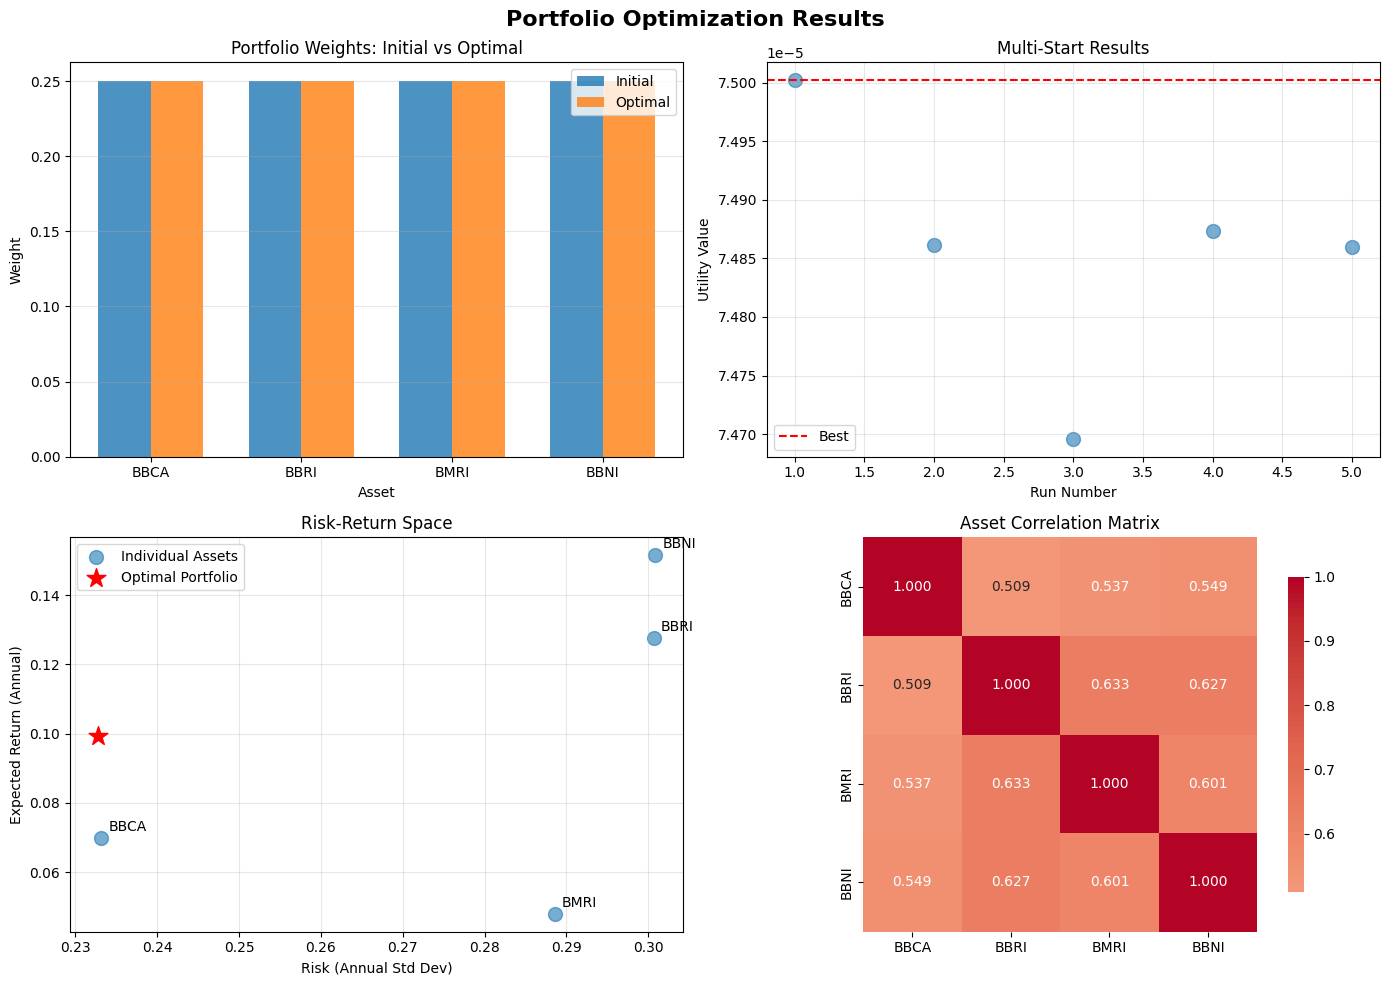

In [106]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Portfolio Optimization Results', fontsize=16, fontweight='bold')

ax1 = axes[0, 0]
x = np.arange(len(ticker_names))
width = 0.35
ax1.bar(x - width/2, w0, width, label='Initial', alpha=0.8)
ax1.bar(x + width/2, w_optimal, width, label='Optimal', alpha=0.8)
ax1.set_xlabel('Asset')
ax1.set_ylabel('Weight')
ax1.set_title('Portfolio Weights: Initial vs Optimal')
ax1.set_xticks(x)
ax1.set_xticklabels(ticker_names)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)
ax1.axhline(y=0, color='k', linestyle='-', linewidth=0.5)

ax2 = axes[0, 1]
if len(successful_runs) > 1:
  run_numbers = [r['run'] for r in successful_runs]
  utilities = [r['utility'] for r in successful_runs]
  ax2.scatter(run_numbers, utilities, s=100, alpha=0.6)
  ax2.axhline(y=u_optimal, color='r', linestyle='--', label='Best')
  ax2.set_xlabel('Run Number')
  ax2.set_ylabel('Utility Value')
  ax2.set_title('Multi-Start Results')
  ax2.legend()
  ax2.grid(alpha=0.3)
else:
  ax2.text(0.5, 0.5, 'Only one successful run',
          ha='center', va='center', transform=ax2.transAxes)
  ax2.set_title('Multi-Start Results')

ax3 = axes[1, 0]
returns_ind = mu * 252
risks_ind = np.sqrt(np.diag(Sigma)) * np.sqrt(252)
ax3.scatter(risks_ind, returns_ind, s=100, alpha=0.6, label='Individual Assets')
for i, name in enumerate(ticker_names):
  ax3.annotate(name, (risks_ind[i], returns_ind[i]),
              xytext=(5, 5), textcoords='offset points')

port_return = expected_return * 252
port_risk = portfolio_std * np.sqrt(252)
ax3.scatter([port_risk], [port_return], s=200, c='red', marker='*',
          label='Optimal Portfolio', zorder=5)

ax3.set_xlabel('Risk (Annual Std Dev)')
ax3.set_ylabel('Expected Return (Annual)')
ax3.set_title('Risk-Return Space')
ax3.legend()
ax3.grid(alpha=0.3)

ax4 = axes[1, 1]
correlation = returns.corr()
sns.heatmap(correlation, annot=True, fmt='.3f', cmap='coolwarm',
          center=0, ax=ax4, square=True, cbar_kws={"shrink": 0.8})
ax4.set_title('Asset Correlation Matrix')

plt.tight_layout()

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f'portfolio_optimization_results_{timestamp}.png'
plt.savefig(filename, dpi=300, bbox_inches='tight')

plt.show()

results_df = pd.DataFrame({
  'Asset': ticker_names,
  'Initial_Weight': w0,
  'Optimal_Weight': w_optimal,
  'Change': w_optimal - w0,
  'Expected_Return': mu,
  'Std_Dev': np.sqrt(np.diag(Sigma)),
  'Skewness': s,
  'Kurtosis': k
})

csv_filename = f'portfolio_optimization_results_{timestamp}.csv'
results_df.to_csv(csv_filename, index=False)
